In [2]:
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import json
import os
import pickle

# Case study 1

### We show how to extract relevant data based on the processed scripts below.

In [10]:
# Initialize list to store results
results_list = []

# Define the ranges for corr_coef, corrupt, and seed as per your requirements
corruption_coeffs = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5]  # Example coefficients
col_corrupt_list = [0, 1, 2, 3, 4, 5, 6, 7]  # Example corrupt values
seeds = range(10)

# Define the method names and corresponding result keys
method_names = {
    'No retraining': 'm1',
    'Partially Updating': 'm2',
    'New model training': 'm3',
    'Ensemble Method': 'm4',
    '$\mathcal{H}$-LLM': 'm5'
}

# Loop over all combinations of corr_coef, corrupt, and seed
for corr_coef in corruption_coeffs:
    for corrupt in col_corrupt_list:
        for seed in seeds:
            try:
                # Load the result
                result = pd.read_pickle(f'../experiments/results/results_corr_{corr_coef}_corrupt_{corrupt}_seed_{seed}.pkl')
                
                # Loop over each method and compute the mean of the last 150 elements of the m component
                for method, m_key in method_names.items():
                    m_values = result[m_key]
                    mean_m = np.array(m_values[-150:]).mean()
                    
                    # Append the result to the list
                    results_list.append({
                        'Method': method,
                        'corr_coef': corr_coef,
                        'corrupt': corrupt,
                        'seed': seed,
                        'mean_result': mean_m
                    })
            except Exception as e:
                print(f'Error processing corr_coef={corr_coef}, corrupt={corrupt}, seed={seed}: {e}')

# Create a DataFrame from the results list
results_df = pd.DataFrame(results_list)

# Display the DataFrame
print(results_df)

Error processing corr_coef=0.01, corrupt=0, seed=2: [Errno 2] No such file or directory: '../experiments/results/results_corr_0.01_corrupt_0_seed_2.pkl'
Error processing corr_coef=0.01, corrupt=0, seed=9: [Errno 2] No such file or directory: '../experiments/results/results_corr_0.01_corrupt_0_seed_9.pkl'
Error processing corr_coef=0.01, corrupt=1, seed=1: [Errno 2] No such file or directory: '../experiments/results/results_corr_0.01_corrupt_1_seed_1.pkl'
Error processing corr_coef=0.01, corrupt=1, seed=4: [Errno 2] No such file or directory: '../experiments/results/results_corr_0.01_corrupt_1_seed_4.pkl'
Error processing corr_coef=0.02, corrupt=0, seed=2: [Errno 2] No such file or directory: '../experiments/results/results_corr_0.02_corrupt_0_seed_2.pkl'
Error processing corr_coef=0.05, corrupt=0, seed=2: [Errno 2] No such file or directory: '../experiments/results/results_corr_0.05_corrupt_0_seed_2.pkl'
Error processing corr_coef=0.05, corrupt=1, seed=5: [Errno 2] No such file or dire

<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\m'
/var/folders/7d/5x5mk9xn5rg4t86x_8_4twk80000gn/T/ipykernel_65715/234286424.py:15: SyntaxWarning: invalid escape sequence '\m'
  '$\mathcal{H}$-LLM': 'm5'


In [18]:
def create_pivot_table(df, corr_coef_value):
    # Filter DataFrame for the given corr_coef
    df_filtered = df[df['corr_coef'] == corr_coef_value]
    
    # Create a pivot table
    pivot_table = df_filtered.pivot_table(index='corrupt', columns='Method', values='mean_result', aggfunc='mean')
    
    return pivot_table

# Create pivot tables for corr_coef = 0.01 and corr_coef = 0.05
pivot_table_0_01 = create_pivot_table(results_df, 0.01).T
pivot_table_0_05 = create_pivot_table(results_df, 0.1).T

In [21]:
display(pivot_table_0_05[[1, 2, 4, 6]])

corrupt,1,2,4,6
Method,,,,
$\mathcal{H}$-LLM,0.897627,0.925065,0.924781,0.722579
Ensemble Method,0.705945,0.707158,0.705859,0.658491
New model training,0.705945,0.707158,0.705859,0.658491
No retraining,0.443575,0.443575,0.443575,0.443584
Partially Updating,0.711013,0.710285,0.711002,0.642191


In [22]:
display(pivot_table_0_01[[1, 2, 4, 6]])

corrupt,1,2,4,6
Method,,,,
$\mathcal{H}$-LLM,0.968529,0.968538,0.968762,0.915893
Ensemble Method,0.876431,0.871531,0.869393,0.853987
New model training,0.876431,0.871531,0.869393,0.853987
No retraining,0.436863,0.437686,0.437686,0.437713
Partially Updating,0.904404,0.909004,0.918984,0.918893


# Case study 2

In [34]:
# Load the JSON data
with open('../experiments/results/0806_v4_real_datasets_experiment_results.json', 'r') as f:
    results = json.load(f)

# Method name mapping
method_names = {
    'batch_learning_no_retraining_wrapper': 'No retraining',
    'adaptive_batch_with_sliding_window_wrapper': 'Partially Updating',
    'adaptive_batch_with_drift_detection_ddm_wrapper': 'New model training',
    'adaptive_ensemble_with_ddm_wrapper': 'Ensemble Method',
    'adaptive_batch_self_healing_wrapper': 'Self-Healing ML'
}

# Initialize lists to store data
vary_cols_data = []
vary_corrupt_val_data = []

# Process the data
for dataset, dataset_results in results.items():
    # Process vary_cols data
    for n_cols_corrupt, methods_data in dataset_results['vary_cols'].items():
        for method, metrics in methods_data.items():
            vary_cols_data.append({
                'Dataset': dataset,
                'N_Cols_Corrupt': int(n_cols_corrupt),
                'Method': method_names[method],
                'Mean_Accuracy': metrics['mean'],
                'Std_Accuracy': metrics['std']
            })
    
    # Process vary_corrupt_val data
    for corrupt_val, methods_data in dataset_results['vary_corrupt_val'].items():
        for method, metrics in methods_data.items():
            vary_corrupt_val_data.append({
                'Dataset': dataset,
                'Corrupt_Val': float(corrupt_val),
                'Method': method_names[method],
                'Mean_Accuracy': metrics['mean'],
                'Std_Accuracy': metrics['std']
            })

# Create dataframes
df_vary_cols = pd.DataFrame(vary_cols_data)
df_vary_corrupt_val = pd.DataFrame(vary_corrupt_val_data)

# Sort the dataframes
df_vary_cols = df_vary_cols.sort_values(['Dataset', 'N_Cols_Corrupt', 'Method'])
df_vary_corrupt_val = df_vary_corrupt_val.sort_values(['Dataset', 'Corrupt_Val', 'Method'])

# Reset index for both dataframes
df_vary_cols = df_vary_cols.reset_index(drop=True)
df_vary_corrupt_val = df_vary_corrupt_val.reset_index(drop=True)

# Process df_vary_cols for k=2
df_vary_cols_k2 = df_vary_cols[df_vary_cols['N_Cols_Corrupt'] == 5].groupby(['Dataset', 'Method'])[['Mean_Accuracy', 'Std_Accuracy']].agg({
    'Mean_Accuracy': 'mean',
    'Std_Accuracy': lambda x: np.mean(x)  # Root mean square of standard deviations
}).reset_index()

# Process df_vary_corrupt_val for tau=10
df_vary_corrupt_val_tau10 = df_vary_corrupt_val[df_vary_corrupt_val['Corrupt_Val'] == 5].groupby(['Dataset', 'Method'])[['Mean_Accuracy', 'Std_Accuracy']].agg({
    'Mean_Accuracy': 'mean',
    'Std_Accuracy': lambda x: np.mean(x)  # Root mean square of standard deviations
}).reset_index()


In [35]:
display(df_vary_cols_k2)

,Dataset,Method,Mean_Accuracy,Std_Accuracy
0,airlines,Ensemble Method,0.507138,0.013622
1,airlines,New model training,0.535165,0.024348
2,airlines,No retraining,0.525786,0.012320
3,airlines,Partially Updating,0.525786,0.012320
4,airlines,Self-Healing ML,0.556629,0.002743
5,covType,Ensemble Method,0.516296,0.022376
6,covType,New model training,0.513837,0.022080
7,covType,No retraining,0.505165,0.034542
8,covType,Partially Updating,0.505165,0.034542
9,covType,Self-Healing ML,0.731721,0.002769


In [37]:
display(df_vary_corrupt_val_tau10)

,Dataset,Method,Mean_Accuracy,Std_Accuracy
0,airlines,Ensemble Method,0.517891,0.010889
1,airlines,New model training,0.533985,0.020179
2,airlines,No retraining,0.528685,0.011113
3,airlines,Partially Updating,0.528685,0.011113
4,airlines,Self-Healing ML,0.556629,0.002743
5,covType,Ensemble Method,0.587457,0.005757
6,covType,New model training,0.575079,0.018664
7,covType,No retraining,0.579739,0.012858
8,covType,Partially Updating,0.579739,0.012858
9,covType,Self-Healing ML,0.731721,0.002769


In [39]:
# Prepare data for LaTeX table
datasets = ['airlines', 'poker', 'weather', 'elec', 'covType']
methods = ['No retraining', 'Partially Updating', 'New model training', 'Ensemble Method', 'Self-Healing ML']

def get_value(df, method, dataset):
    value = df[(df['Method'] == method) & (df['Dataset'] == dataset)]
    if not value.empty:
        return f"{value['Mean_Accuracy'].values[0]:.2f} $\\pm$ {value['Std_Accuracy'].values[0]:.2f}"
    return "N/A"

# Generate LaTeX table
latex_table = r"""\begin{table}[ht]
\scriptsize
\setlength{\tabcolsep}{2.8pt}
\centering
\begin{tabular}{@{}lccccc|ccccc@{}}
\toprule
& \multicolumn{5}{c|}{\textbf{Accuracy when $k=2$ and $\tau = 10$}} & \multicolumn{5}{c}{\textbf{Accuracy when corruption value $\tau$ = 10}} \\
\textit{Method} & airlines & poker & weather & elec & covType & airlines & poker & weather & elec & covType \\
\midrule
"""

for method in methods:
    row = [method]
    for dataset in datasets:
        row.append(get_value(df_vary_cols_k2, method, dataset))
    for dataset in datasets:
        row.append(get_value(df_vary_corrupt_val_tau10, method, dataset))
    
    latex_row = " & ".join(row)
    if method == 'Self-Healing ML':
        latex_row = r"\hline \textbf{" + latex_row + r"}"
    latex_table += latex_row + r" \\" + "\n"

latex_table += r"""\bottomrule
\end{tabular}
\caption{Accuracy of various methods on different datasets with corrupted columns and varying corruption values. Error represents standard errors. $\uparrow$ is better.}
\label{tab:corrupted_exp}
\end{table}"""

print(latex_table)

\begin{table}[ht]
\scriptsize
\setlength{\tabcolsep}{2.8pt}
\centering
\begin{tabular}{@{}lccccc|ccccc@{}}
\toprule
& \multicolumn{5}{c|}{\textbf{Accuracy when $k=2$ and $\tau = 10$}} & \multicolumn{5}{c}{\textbf{Accuracy when corruption value $\tau$ = 10}} \\
\textit{Method} & airlines & poker & weather & elec & covType & airlines & poker & weather & elec & covType \\
\midrule
No retraining & 0.53 $\pm$ 0.01 & 0.48 $\pm$ 0.01 & 0.57 $\pm$ 0.05 & 0.66 $\pm$ 0.04 & 0.51 $\pm$ 0.03 & 0.53 $\pm$ 0.01 & 0.47 $\pm$ 0.01 & 0.59 $\pm$ 0.04 & 0.67 $\pm$ 0.03 & 0.58 $\pm$ 0.01 \\
Partially Updating & 0.53 $\pm$ 0.01 & 0.48 $\pm$ 0.01 & 0.57 $\pm$ 0.05 & 0.66 $\pm$ 0.04 & 0.51 $\pm$ 0.03 & 0.53 $\pm$ 0.01 & 0.47 $\pm$ 0.01 & 0.59 $\pm$ 0.04 & 0.67 $\pm$ 0.03 & 0.58 $\pm$ 0.01 \\
New model training & 0.54 $\pm$ 0.02 & 0.49 $\pm$ 0.01 & 0.56 $\pm$ 0.03 & 0.66 $\pm$ 0.05 & 0.51 $\pm$ 0.02 & 0.53 $\pm$ 0.02 & 0.47 $\pm$ 0.00 & 0.60 $\pm$ 0.02 & 0.67 $\pm$ 0.03 & 0.58 $\pm$ 0.02 \\
Ensemble Method & 

# Case study 3

In [3]:
# Initialize an empty list to store the result dictionaries
results_ls = []
results_dir = '../experiments/results/'

# Iterate over all files in the results directory
for filename in os.listdir(results_dir):
    # Check if the filename matches the expected pattern
    if filename.startswith('results_threshold_') and filename.endswith('.pkl'):
        filepath = os.path.join(results_dir, filename)
        
        # Load the pickle file
        with open(filepath, 'rb') as f:
            result = pickle.load(f)
            results_ls.append(result)
        
result = results_ls[0]
t5 = result['t5']
m5 = result['m5']

intervention_point = 186
recovery_criterion_above_acc = 0.76

import os
import pickle
import pandas as pd

# Calculate how quickly recovered (in days above the recovery criterion)
def calculate_recovery_time(m5, intervention_point, recovery_criterion):
    post_intervention = m5[intervention_point + 1:]
    for i, accuracy in enumerate(post_intervention):
        if accuracy > recovery_criterion:
            return i + 1  # Adding 1 because list index is 0-based
    return None  # If recovery criterion is never met

# Function to calculate post-intervention accuracy
def calculate_post_intervention_accuracy(m5, intervention_point, t=100):
    post_intervention = m5[intervention_point:intervention_point + t]
    if len(post_intervention) < t:
        raise ValueError("Not enough points after intervention to calculate post-intervention accuracy")
    return sum(post_intervention) / len(post_intervention)

# Function to calculate overall accuracy
def calculate_overall_accuracy(m5):
    return sum(m5) / len(m5)

# Given intervention point and recovery criterion
intervention_point = 185
recovery_criterion_above_acc = 0.76

# List to hold all results for DataFrame
all_results = []

# Iterate over all results in results_ls
for result in results_ls:
    info = result['info']
    t5 = result['t5']
    m5 = result['m5']
    
    # Calculate metrics
    recovery_time = calculate_recovery_time(m5, intervention_point, recovery_criterion_above_acc)
    post_intervention_accuracy = calculate_post_intervention_accuracy(m5, intervention_point, t=100)
    overall_accuracy = calculate_overall_accuracy(m5)
    
    # Create a dictionary for this result
    result_dict = {
        'seed': info['seed'],
        'threshold': info['threshold'],
        'warm_start': info['warm_start'],
        'recovery_time': recovery_time,
        'post_intervention_accuracy': post_intervention_accuracy,
        'overall_accuracy': overall_accuracy
    }
    
    # Append the result dictionary to the list
    all_results.append(result_dict)

# Create a DataFrame from the list of dictionaries
results_df = pd.DataFrame(all_results)




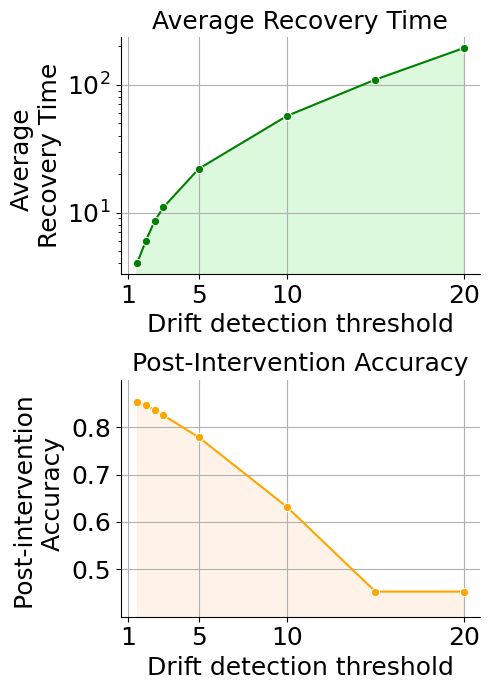

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming results_df is the DataFrame created in the previous steps

# Filter for warm_start equal to 5 and threshold greater than 1.2
filtered_df = results_df[(results_df['warm_start'] == 5) & (results_df['threshold'] > 1.2)]

# Group by threshold and calculate the mean recovery time and post_intervention_accuracy
mean_values = filtered_df.groupby('threshold').agg({
    'recovery_time': 'mean',
    'post_intervention_accuracy': 'mean'
}).reset_index()

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(5, 7))

# Customizable font sizes
title_fontsize = 18
labels_fontsize = 18
ticks_fontsize = 18

# Define colors for the plots
recovery_color = 'green'
accuracy_color = 'orange'
recovery_fill_color = 'lightgreen'
accuracy_fill_color = '#FFDAB9'

# Plot the first subplot (recovery time)
sns.lineplot(data=mean_values, x='threshold', y='recovery_time', marker='o', color=recovery_color, ax=axes[0])
axes[0].fill_between(mean_values['threshold'], mean_values['recovery_time'], color=recovery_fill_color, alpha=0.3)
axes[0].set_xlabel('Drift detection threshold', fontsize=labels_fontsize)
axes[0].set_ylabel('Average \nRecovery Time', fontsize=labels_fontsize)
axes[0].set_yscale('log')
axes[0].set_title('Average Recovery Time', fontsize=title_fontsize)
axes[0].grid(True)

# Set x-axis ticks
axes[0].set_xticks([1, 5, 10, 20])
axes[0].tick_params(axis='x', labelsize=ticks_fontsize)
axes[0].tick_params(axis='y', labelsize=ticks_fontsize)

# Plot the second subplot (post-intervention accuracy)
sns.lineplot(data=mean_values, x='threshold', y='post_intervention_accuracy', marker='o', color=accuracy_color, ax=axes[1])
axes[1].fill_between(mean_values['threshold'], mean_values['post_intervention_accuracy'], color=accuracy_fill_color, alpha=0.3)
axes[1].set_xlabel('Drift detection threshold', fontsize=labels_fontsize)
axes[1].set_ylabel('Post-intervention \n Accuracy', fontsize=labels_fontsize)
axes[1].set_title('Post-Intervention Accuracy', fontsize=title_fontsize)
axes[1].grid(True)
axes[1].set_ylim((0.4, 0.9))

# Set x-axis ticks
axes[1].set_xticks([1, 5, 10, 20])
axes[1].tick_params(axis='x', labelsize=ticks_fontsize)
axes[1].tick_params(axis='y', labelsize=ticks_fontsize)

# Set y-axis ticks for the second plot
axes[1].set_yticks([0.5, 0.6, 0.7, 0.8])

# Adjusting y-axis tick labels font size and removing top and right spines
for ax in axes:
    ax.spines[['right', 'top']].set_visible(False)

# Adjust layout and show plot
plt.tight_layout()
#fig.savefig('drift_detection2.pdf')
plt.show()


# Case study 4

In [5]:
# Read data
import pandas as pd
import os
import pickle

def load_results_outlier(directory):
    results = []
    for filename in os.listdir(directory):
        if filename.startswith('quality_of_info_outlier') and filename.endswith('.pkl'):
            with open(os.path.join(directory, filename), 'rb') as f:
                results.append(pickle.load(f))
    return results

def load_results_corrupt(directory):
    results = []
    for filename in os.listdir(directory):
        if 'quality_of_info_corrupt_' in filename and filename.endswith('.pkl'):
            with open(os.path.join(directory, filename), 'rb') as f:
                results.append(pickle.load(f))
    return results

# Define the directory where the pickle files are stored
directory = '../experiments/results'

# Load the results from the pickle files
results_outlier = load_results_outlier(directory)
results_corrupt = load_results_corrupt(directory)
results = results_corrupt
results2 = results_outlier

# Convert the loaded results into DataFrames
df = pd.DataFrame(results_outlier, columns=['outlier_factor', 'seed', 'd_quality', 'kl_quality'])
df2 = pd.DataFrame(results_corrupt, columns=['corrupt_coef', 'seed', 'd_quality', 'kl_quality'])


In [6]:
import math
def compute_kl_divergence(distribution_p, distribution_q):
    """Compute the KL divergence between two distributions."""
    kl_divergence = 0.0
    for key in distribution_p:
        p_prob = distribution_p[key]
        q_prob = distribution_q.get(key, 0)
        if p_prob > 0 and q_prob > 0:  # Ensure no division by zero or log(0)
            kl_divergence += p_prob * math.log(p_prob / q_prob)
    return kl_divergence

true_probabilities = {'Age': 1,
 'HbA1c': 0,
 'FastingGlucose': 0,
 'BMI': 0,
 'BloodPressure': 0,
 'Cholesterol': 0,
 'Insulin': 0,
 'PhysicalActivity': 0}

uniform_prob = {key: 1 / len(true_probabilities) for key in true_probabilities}

kld = compute_kl_divergence(true_probabilities, uniform_prob)

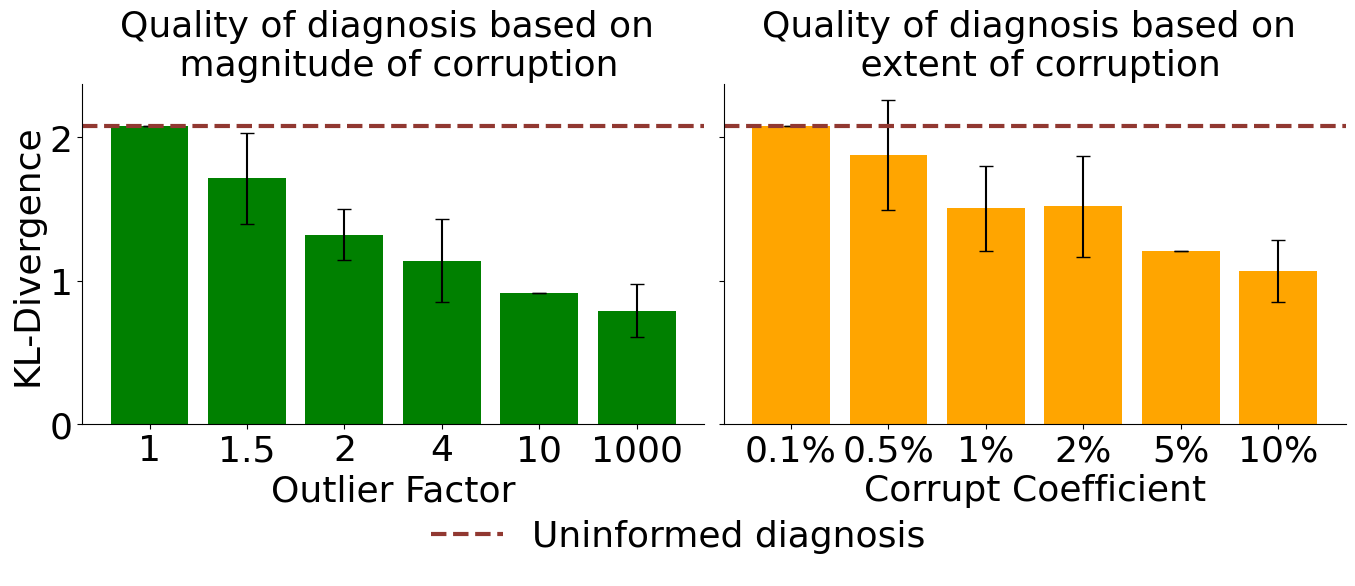

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Create DataFrames from the given lists
df_outliers = pd.DataFrame(results2, columns=['outlier_factor', 'seed', 'd_quality', 'kl_quality'])
df_corrupt = pd.DataFrame(results, columns=['corrupt_coef', 'seed', 'd_quality', 'kl_quality'])

# Specified values for the plots
outlier_factors = [1, 1.5, 2, 4, 10, 1000]
corrupt_coef = [0.001, 0.005, 0.01, 0.02, 0.05, 0.1]

# Filter the DataFrames based on specified outlier_factors and corrupt_coef
df_outliers_filtered = df_outliers[df_outliers['outlier_factor'].isin(outlier_factors)]
df_corrupt_filtered = df_corrupt[df_corrupt['corrupt_coef'].isin(corrupt_coef)]

# Calculate the mean and standard deviation for kl_quality grouped by outlier_factor and corrupt_coef
kl_quality_outliers_stats = df_outliers_filtered.groupby('outlier_factor')['kl_quality'].agg(['mean', 'std'])
kl_quality_corrupt_stats = df_corrupt_filtered.groupby('corrupt_coef')['kl_quality'].agg(['mean', 'std'])

# Customizable font sizes
title_fontsize = 26
xlabel_fontsize = 26
ylabel_fontsize = 26
xticks_fontsize = 26
yticks_fontsize = 26
legend_fontsize = 20

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6), sharey=True)

# Plotting kl_quality for outlier_factors
axes[0].bar(range(len(kl_quality_outliers_stats)), kl_quality_outliers_stats['mean'], 
            yerr=kl_quality_outliers_stats['std'], capsize=5, color='green')
axes[0].set_xticks(range(len(kl_quality_outliers_stats)))
axes[0].set_xticklabels([1, 1.5, 2, 4, 10, 1000], fontsize=xticks_fontsize)
axes[0].set_xlabel('Outlier Factor', fontsize=xlabel_fontsize)
axes[0].set_ylabel('KL-Divergence', fontsize=ylabel_fontsize)
axes[0].set_title('Quality of diagnosis based on \n magnitude of corruption', fontsize=title_fontsize)
axes[0].axhline(y=kld, color='#913831', linestyle='--', linewidth=3, label='Uninformed diagnosis')

# Plotting kl_quality for corrupt_coef
axes[1].bar(range(len(kl_quality_corrupt_stats)), kl_quality_corrupt_stats['mean'], 
            yerr=kl_quality_corrupt_stats['std'], capsize=5, color='orange')
axes[1].set_xticks(range(len(kl_quality_corrupt_stats)))
axes[1].set_xticklabels(['0.1%', '0.5%', '1%', '2%', '5%', '10%'], fontsize=xticks_fontsize)
axes[1].set_xlabel('Corrupt Coefficient', fontsize=xlabel_fontsize)
axes[1].set_title('Quality of diagnosis based on \n extent of corruption', fontsize=title_fontsize)
axes[1].axhline(y=kld, color='#913831', linestyle='--', linewidth=3, label='Uninformed diagnosis')

# Adjusting y-axis tick labels font size
for ax in axes:
    ax.tick_params(axis='y', labelsize=yticks_fontsize)
    ax.spines[['right', 'top']].set_visible(False)

# Create a single legend for both plots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=1, frameon=False, fontsize=xticks_fontsize)

plt.tight_layout(rect=[0, 0.12, 1, 1])  # Adjust layout to make space for the legend

fig.savefig('quality_diagnosis_corruption.pdf')
plt.show()


# Case study 5

In [11]:
# Open the .pkl file in binary read mode
with open('../experiments/results/accs_dict.pkl', 'rb') as file:
    accs_dict = pickle.load(file)

data = []
for key, values in accs_dict.items():
    for value in values:
        data.append({'n': key, 'accuracy': value})

df = pd.DataFrame(data)


/var/folders/7d/5x5mk9xn5rg4t86x_8_4twk80000gn/T/ipykernel_74344/1406738452.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=df, x='n', y='accuracy', palette='dark', boxprops={'alpha': 0.6})
/var/folders/7d/5x5mk9xn5rg4t86x_8_4twk80000gn/T/ipykernel_74344/1406738452.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["2%", "5%", "10%", "20%", "50%", "75%", "N=7", "N=8"], fontsize=tick_fontsize)


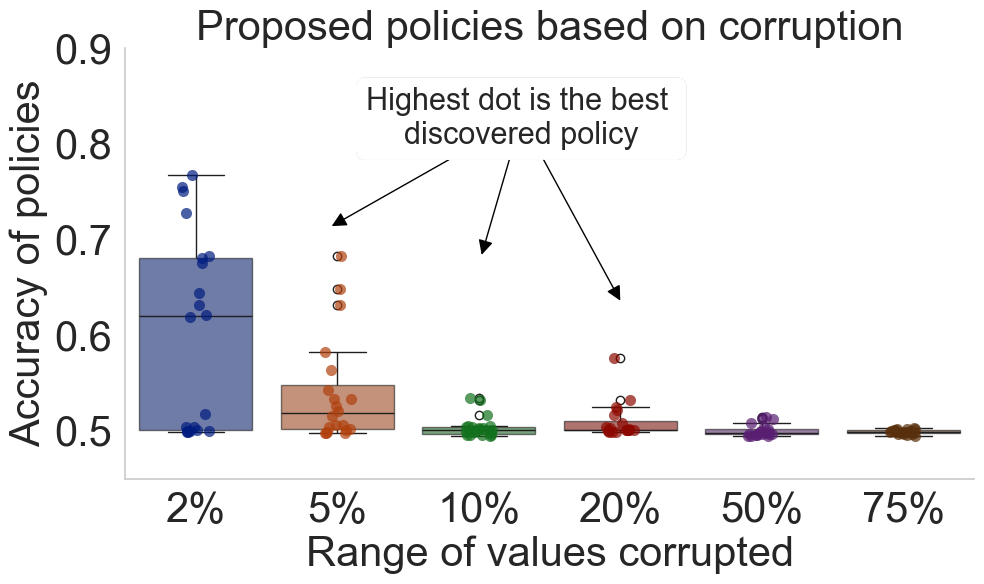

In [12]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid")
np.random.seed(42)
# Define the font sizes
label_fontsize = 30
title_fontsize = 30
tick_fontsize = 30

# Create the boxplot with seaborn using a darker palette
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=df, x='n', y='accuracy', palette='dark', boxprops={'alpha': 0.6})

# Add the scatter plot on top of the boxplot with matching colors
palette = sns.color_palette('dark')
for i, (key, values) in enumerate(accs_dict.items()):
    sns.stripplot(x=[key]*len(values), y=values, jitter=True, marker='o', size=8, alpha=0.7, color=palette[i], ax=ax)

# Customize the plot
ax.set_xlabel('Range of values corrupted', fontsize=label_fontsize)
ax.set_ylabel('Accuracy of policies', fontsize=label_fontsize)
ax.set_title('Proposed policies based on corruption', fontsize=title_fontsize)
ax.set_ylim((0.45, 0.9))

# Customize tick labels
ax.set_xticklabels(["2%", "5%", "10%", "20%", "50%", "75%", "N=7", "N=8"], fontsize=tick_fontsize)
ax.tick_params(axis='y', labelsize=tick_fontsize)

# Remove gridlines
ax.grid(False)

# Remove the top and right spines
sns.despine()

# Annotate with an arrow
# Annotate with an arrow
arrowprops = dict(facecolor='black', edgecolor='black', arrowstyle='-|>', linewidth=1, shrinkA=0, shrinkB=0)
txt = "Highest dot is the best \ndiscovered policy"
fsize = 22
ax.annotate(txt,
            xy=(0.96, 0.71411764705882),  # point to one of the dots (example coordinates)
            xytext=(2.3, 0.8),  # text location
            arrowprops=arrowprops,
            fontsize=fsize,
            ha='center',
            bbox=dict(boxstyle="round,pad=0.3", edgecolor='grey', facecolor='white'))

ax.annotate(txt,
            xy=(2.02, 0.68411764705882),  # point to one of the dots (example coordinates)
            xytext=(2.3, 0.8),  # text location
            arrowprops=arrowprops,
            fontsize=fsize,
            ha='center',
            bbox=dict(boxstyle="round,pad=0.3", edgecolor='white', facecolor='white'))

ax.annotate(txt,
            xy=(3.0, 0.63611764705882),  # point to one of the dots (example coordinates)
            xytext=(2.3, 0.8),  # text location
            arrowprops=arrowprops,
            fontsize=fsize,
            ha='center',
            bbox=dict(boxstyle="round,pad=0.3", edgecolor='white', facecolor='white'))
plt.tight_layout()
plt.savefig('policies_corruption.pdf')
# Show the plot
plt.show()

In [27]:
# Open the .pkl file in binary read mode
with open('../experiments/results/accs_dict_backtesting_window.pkl', 'rb') as file:
    accs_dict = pickle.load(file)

#t the dictionary to a DataFrame
data = []
for key, values in accs_dict.items():
    for value in values:
        data.append({'n': key, 'accuracy': value})

df = pd.DataFrame(data)

plot_df = df[df['n'].isin([10, 100, 1000, 10_000, 100_000])]

/var/folders/7d/5x5mk9xn5rg4t86x_8_4twk80000gn/T/ipykernel_74344/1296984338.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=plot_df, x='n', y='accuracy', palette='dark', boxprops={'alpha': 0.6})
/var/folders/7d/5x5mk9xn5rg4t86x_8_4twk80000gn/T/ipykernel_74344/1296984338.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([r"$10$", r"$10^2$", r"$10^3$", r"$10^4$", r"$10^5$"], fontsize=tick_fontsize)


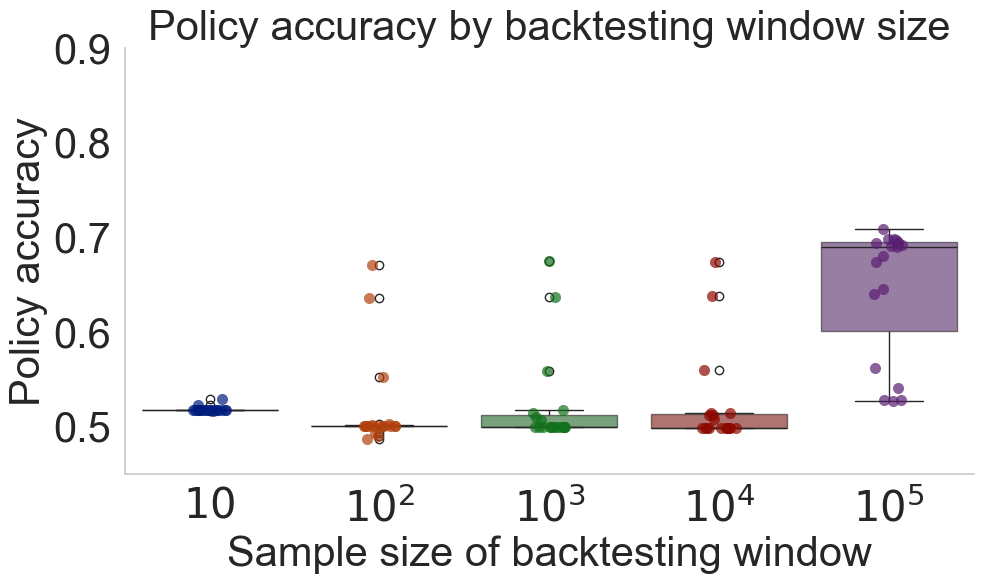

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming df is already defined and contains the necessary columns 'n' and 'accuracy'
# If not, load your DataFrame here
# df = pd.read_csv('your_data.csv')

# Filter the DataFrame for specific sample sizes
plot_df = df[df['n'].isin([10, 100, 1000, 10_000, 100_000])]

# Set the aesthetic style of the plots
sns.set(style="whitegrid")
np.random.seed(42)

# Define the font sizes
label_fontsize = 30
title_fontsize = 30
tick_fontsize = 30

# Create the boxplot with seaborn using a darker palette
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=plot_df, x='n', y='accuracy', palette='dark', boxprops={'alpha': 0.6})

# Define the palette for the scatter plot
palette = sns.color_palette('dark')

# Add the scatter plot on top of the boxplot with matching colors
unique_ns = plot_df['n'].unique()
for i, key in enumerate(unique_ns):
    if key in accs_dict:
        values = accs_dict[key]
        sns.stripplot(x=[key]*len(values), y=values, jitter=True, marker='o', size=8, alpha=0.7, color=palette[i % len(palette)], ax=ax)

# Customize the plot
ax.set_xlabel('Sample size of backtesting window', fontsize=label_fontsize)
ax.set_ylabel('Policy accuracy', fontsize=label_fontsize)
ax.set_title('Policy accuracy by backtesting window size', fontsize=title_fontsize)
ax.set_ylim((0.45, 0.9))

# Customize tick labels
ax.set_xticklabels([r"$10$", r"$10^2$", r"$10^3$", r"$10^4$", r"$10^5$"], fontsize=tick_fontsize)
ax.tick_params(axis='y', labelsize=tick_fontsize)

# Remove gridlines
ax.grid(False)

# Remove the top and right spines
sns.despine()

plt.tight_layout()
# Show the plot
plt.show()


# Case study 6

To evaluate the effectiveness of the backtesting window, we simply need to demonstrate that the action chosen on the basis of the testing module results in higher performance than the accuracy of the top hypothesis without the corresponding testing module results. Therefore, a simple max comparison can give us this result.

Note: The results are expected to vary each time on the basis of how well the language model manages to hypothesize the most likely outcome. We assume that the testing module, in this case, the backtesting window, is a representative data slice on the basis of which we can draw inferences on the upcoming data.

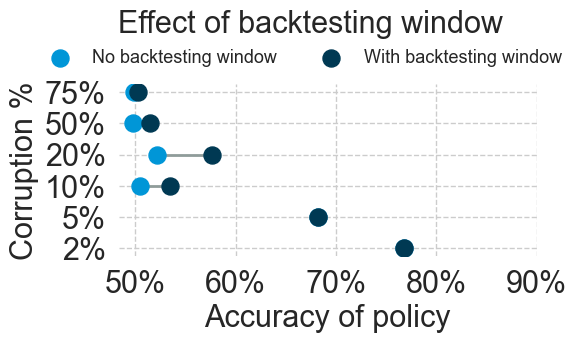

In [40]:
# Open the .pkl file in binary read mode
with open('../experiments/results/accs_dict.pkl', 'rb') as file:
    accs_dict = pickle.load(file)

data = []
for key, values in accs_dict.items():
    for value in values:
        data.append({'n': key, 'accuracy': value})

df = pd.DataFrame(data)

accs_dict.keys()# Creating the new dictionary
new_dict = {}
for key, value_list in accs_dict.items():
    first_number = value_list[0]
    argmax_index = max(value_list)
    new_dict[key] = [first_number, argmax_index]

df_results = pd.DataFrame(new_dict).T

import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(6, 4))
sns.set_style("whitegrid", {'grid.linestyle': '--'})
my_range = range(1, 7)
ticklabels = ["2%", "5%", "10%", "20%", "50%", "75%"]
title_fontsize = 22
label_fontsize = 22

ax = plt.axes(frameon=False)
plt.hlines(y=my_range, xmin=df_results[0], xmax=df_results[1], color='#8f9c9a', lw=2)
plt.scatter(df_results[0], my_range, color='#0096d7', s=150, label='No backtesting window', zorder=3)
plt.scatter(df_results[1], my_range, color='#003953', s=150, label='With backtesting window', zorder=3)

# Add legend and title
legend = plt.legend(ncol=2, bbox_to_anchor=(1.1, 1.01), loc='lower right', frameon=False, fontsize=13)
plt.text(0.92, 1.3, "Effect of backtesting window", fontsize=title_fontsize, ha='right', transform=ax.transAxes)

plt.yticks(my_range, ticklabels, fontsize=title_fontsize)

# Set specific x-axis labels
x_labels = [0.5, 0.6, 0.7, 0.8, 0.9]
x_labels_percentage = [f"{int(label * 100)}%" for label in x_labels]
plt.xticks(x_labels, x_labels_percentage, fontsize=title_fontsize)
plt.ylabel("Corruption %", fontsize=label_fontsize)

plt.xlabel("Accuracy of policy", fontsize=label_fontsize)
plt.tight_layout()
plt.savefig('backtesting.pdf')
plt.show()
